In [158]:
# from alive_progress import alive_bar
# from fake_useragent import UserAgent
from json import JSONDecodeError
from datetime import datetime
from functools import reduce
from random import randint
from random import seed
import requests
import pandas as pd
import random
import timeit
import time

import numpy as np
import pickle
import urllib

import pickle
import json
import os
import math
import asyncio
from urllib.error import HTTPError
import aiohttp
import platform
from datetime import datetime
import requests
import statistics
from aiohttp import ClientSession
import matplotlib.pyplot as plt

In [159]:
class PegaxyExtractor:

    def __init__(self):
        self.data = []
        self.filename = 'all_pegas {}.pkl'.format(datetime.now().strftime("%Y%m%d"))

        self.url1 = ""
        self.url2 = ""
        self.url3 = ""
        
#         ua = UserAgent()
        # header = {'User-Agent':str(ua.firefox)}
        # ua.random

        user_agent_list = [
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0',
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
#             ua.chrome,
#             ua.firefox
        ]

    def get_count(self):
        r = requests.get("https://api-apollo.pegaxy.io/v1/game-api/market/pegasListing/{id}?&marketType=FixedPrice&currency=0xc2132D05D31c914a87C6611C10748AEb04B58e8F&breedFrom=0&breedTo=7")
        print("Getting {} Pegas, {} pages".format(r.json()['total'], math.ceil(r.json()['total'] / 12)))
        return math.ceil(r.json()['total'] / 12)
    def transform(self, data):
        pega_details = []

        for iteration in data:
            for pega in iteration:
                pega_details.append(pega)
        
        self.save(pega_details)

    def save(self, data, filename=None):
        if filename is None:
            filename = self.filename

        file = open(filename, 'wb')
        pickle.dump(data, file)
    def load(self, filename=None):
        if filename is None:
            filename = self.filename
        with open(filename, 'rb') as f:
            print(filename)
            pega_details = pickle.load(f) 
            print(len(pega_details))
        return pega_details

    async def get_pega(
        self,
        session: aiohttp.ClientSession,
        id: int,
        **kwargs
    ) -> dict:        
        url = f"https://api-apollo.pegaxy.io/v1/game-api/market/listing/{id}"
        # url = f"https://api-apollo.pegaxy.io/v1/game-api/pega/{id}"
        response = await session.request('GET', url=url, **kwargs)
        details = await response.json()
        return details
    async def get_market_pegas(
        self,
        session: aiohttp.ClientSession,
        id: int,
        **kwargs
    ) -> dict:

        url = f"https://api-apollo.pegaxy.io/v1/game-api/market/pegasListing/{id}?&marketType=FixedPrice&currency=0xc2132D05D31c914a87C6611C10748AEb04B58e8F&breedFrom=0&breedTo=7"

        response = await session.request('GET', url=url, **kwargs)
        # Note that this may raise an exception for non-2xx responses
        # You can either handle that here, or pass the exception through
        data = await response.json()

        return data['market']        

    async def start(self, pages):
        async with ClientSession() as session:
            tasks = [] 

            for i in range(pages):
                tasks.append(self.get_market_pegas(session=session, id=i))

            data = await asyncio.gather(*tasks, return_exceptions=True)
            self.transform(data)
    async def get_deets(self):
        async with ClientSession() as session:
            tasks = [] 

            pegas = self.load()

            for pega in pegas:
                tasks.append(self.get_pega(session=session, id=pega['id']))

            data = await asyncio.gather(*tasks, return_exceptions=True)
            self.save(data)


# Initiating Transformation

In [160]:
# Start Transformation
if __name__ == '__main__':
    ext = PegaxyExtractor()
    
# pegas = ext.load('all_pegas 20220213.pkl')
    pegas = ext.load()
    transformed = []
    for idx, pega in enumerate(pegas):
        new_pega = {}
        if type(pega) is not dict:
            del pegas[idx]

        if type(pega) is dict:
            new_pega['id'] = pega['listing']['id']      
            new_pega['nftId'] = pega['nft']['id']      
            new_pega['ownerId'] = pega['nft']['ownerId']
            new_pega['nftAddress'] = pega['listing']['nft']
            
            if 'nft' in pega and 'total_races' in pega['nft'] and pega['nft']['total_races'] != 0:
                win_rate = "{:.2f}".format((pega['nft']['win'] / pega['nft']['total_races'])*100)
                new_pega['win_rate'] = win_rate 
            if  math.floor(pega['nft']['speed']) > 0 and math.floor(pega['nft']['strength']) > 0 and math.floor(pega['nft']['wind']) > 0 and \
                math.floor(pega['nft']['water']) > 0 and math.floor(pega['nft']['fire']) > 0 and math.floor(pega['nft']['lighting']) > 0:
                new_pega['stats_decent'] = True
            else:
                new_pega['stats_decent'] = False
            
            
            stats_agg = statistics.fmean([pega['nft']['speed'], pega['nft']['strength'], pega['nft']['wind'], pega['nft']['water'], pega['nft']['fire'], pega['nft']['lighting']])
            new_pega['stats_agg'] = "{:.2f}".format(stats_agg)
                
            rng_agg = statistics.fmean([pega['nft']['wind'], pega['nft']['water'], pega['nft']['fire'], pega['nft']['lighting']])
            new_pega['rng_agg'] = "{:.2f}".format(rng_agg)
            
            new_pega['price'] = "{:}".format(int(pega['listing']['price'])/1000000)
            new_pega['speed'] = pega['nft']['speed']
            new_pega['strength'] = pega['nft']['strength']
            new_pega['lightning'] = pega['nft']['lighting']
            new_pega['wind'] = pega['nft']['wind'] 
            new_pega['water'] = pega['nft']['water']
            new_pega['fire'] = pega['nft']['fire']
            new_pega['wins'] = pega['nft']['win']
            new_pega['loss'] = pega['nft']['lose']
            new_pega['total_races'] = pega['nft']['total_races']
            new_pega['breedTime'] = pega['nft']['breedTime']
            new_pega['owner'] = pega['listing']['owner']['address']
            new_pega['name'] = pega['nft']['name']
            new_pega['bloodline'] = pega['nft']['bloodLine']
            new_pega['breedType'] = pega['nft']['breedType']        
            new_pega['inService'] = pega['nft']['inService']
            new_pega['gender'] = pega['nft']['gender']
        
        transformed.append(new_pega)
            
    df = pd.DataFrame(transformed)
    df.head()

all_pegas 20220220.pkl
1081


In [161]:
df['id'] = df['id'].astype(str).apply(lambda x: x.replace('.0',''))
df['nftId'] = df['nftId'].astype(str).apply(lambda x: x.replace('.0',''))
df['ownerId'] = df['ownerId'].astype(str).apply(lambda x: x.replace('.0',''))
df['stats_agg'] = df['stats_agg'].astype(float)
df['rng_agg'] = df['rng_agg'].astype(float)
# Change NAs to 0
# df['wins'] = df['wins'].astype(int)
df['loss'] = df['loss'].astype(float)
df['total_races'] = df['total_races'].astype(float)
df['price'] = df['price'].astype(float)
df['win_rate'] = df['win_rate'].astype(float)


# df = df.drop(labels=['message', 'status', 'listing', 'nft'], axis=1)
df = df.dropna();

# column_names = ["id", "name", "win_rate", "price", "rng_agg", "stats_decent", "speed", "strength", "lightning", "wind", "water", "fire", "stats_agg", "breedTime", "wins","loss","total_races", "bloodline", "breedType", "inService", "gender", "nftId", "ownerId", "owner", "nftAddress"]
column_names = ["id", "name", "win_rate", "price", "rng_agg", "stats_agg", "stats_decent", "speed", "strength", "lightning", "wind", "water", "fire", "breedTime", "wins","loss","total_races","bloodline","gender"]
df = df.reindex(columns=column_names)

df = df.sort_values(by=['win_rate'], ascending=False);
df.round(2)
df.set_index('id', inplace=True)
df.shape
df.head()


,name,win_rate,price,rng_agg,stats_agg,stats_decent,speed,strength,lightning,wind,water,fire,breedTime,wins,loss,total_races,bloodline,gender
id,,,,,,,,,,,,,,,,,,
52651,red,78.75,649000.0,6.59,6.50,True,6.69,5.96,7.22,3.17,8.46,7.52,0.0,278.0,75.0,353.0,Campona,Female
11211,Mirage,67.62,24000.0,4.81,4.79,False,2.19,7.30,4.10,6.93,7.27,0.95,0.0,213.0,102.0,315.0,Campona,Female
201798,X925 | Angela Merkel,54.17,2750.0,7.32,7.14,True,6.02,7.57,8.18,7.43,6.79,6.88,0.0,13.0,11.0,24.0,Hoz,Male
88832,Shiny Pegasus,54.17,99000.0,5.55,5.60,True,5.86,5.54,6.59,7.56,6.70,1.35,0.0,143.0,121.0,264.0,Hoz,Female
185311,Hoz Light Speed,48.55,31000.0,4.01,4.68,False,3.84,8.20,0.85,6.80,7.57,0.84,0.0,235.0,249.0,484.0,Hoz,Male


# Segmentation by Win Rate

In [162]:
win_rate1 = df[df['win_rate'] < 19]
win_rate2 = df[(df['win_rate'] > 19) & (df['win_rate'] <= 30)]
win_rate3 = df[(df['win_rate'] > 30) & (df['win_rate'] <= 40)]
win_rate4 = df[(df['win_rate'] > 40) & (df['win_rate'] <= 50)]
win_rate5 = df[df['win_rate'] > 50]

In [163]:
total = len(win_rate1) + len(win_rate2) + len(win_rate3) + len(win_rate4) + len(win_rate5)
print("Total pegas for today: {}".format(total))

Total pegas for today: 650


Less than 19% --- 1.85%   [12]
19% - 30% --- 83.38%   [542]
30% - 40% --- 12.62%   [82]
40% - 50% --- 1.54%   [10]
More than 50% --- 0.62%   [4]


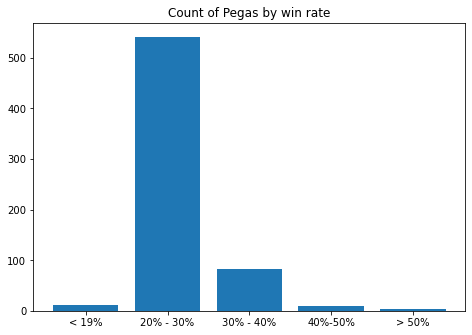

In [164]:
print("Less than 19% --- {:.2f}%   [{}]".format(((len(win_rate1) / total)*100), len(win_rate1)))
print("19% - 30% --- {:.2f}%   [{}]".format(((len(win_rate2) / total)*100), len(win_rate2)))
print("30% - 40% --- {:.2f}%   [{}]".format(((len(win_rate3) / total)*100), len(win_rate3)))
print("40% - 50% --- {:.2f}%   [{}]".format(((len(win_rate4) / total)*100), len(win_rate4)))
print("More than 50% --- {:.2f}%   [{}]".format(((len(win_rate5) / total)*100), len(win_rate5)))

buckets = ['< 19%','20% - 30%','30% - 40%','40%-50%','> 50%']
bucket_counts = [len(win_rate1), len(win_rate2), len(win_rate3), len(win_rate4), len(win_rate5)]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Count of Pegas by win rate')


ax.bar(buckets, bucket_counts)
plt.show()

# Top Pega Analysis

In [165]:
top_pegas = df[(df['total_races'] >= 200)] 
top_pegas = top_pegas.sort_values(by=['win_rate'], ascending=False)
top_pegas = top_pegas.iloc[:10]

print("Mean Total Stats:     {:.2f}".format(top_pegas['stats_agg'].mean()));
print("Mean RNG Stats:       {:.2f}".format(top_pegas['rng_agg'].mean()));
top_pegas

Mean Total Stats:     5.41
Mean RNG Stats:       5.35


,name,win_rate,price,rng_agg,stats_agg,stats_decent,speed,strength,lightning,wind,water,fire,breedTime,wins,loss,total_races,bloodline,gender
id,,,,,,,,,,,,,,,,,,
52651,red,78.75,649000.0,6.59,6.50,True,6.69,5.96,7.22,3.17,8.46,7.52,0.0,278.0,75.0,353.0,Campona,Female
11211,Mirage,67.62,24000.0,4.81,4.79,False,2.19,7.30,4.10,6.93,7.27,0.95,0.0,213.0,102.0,315.0,Campona,Female
88832,Shiny Pegasus,54.17,99000.0,5.55,5.60,True,5.86,5.54,6.59,7.56,6.70,1.35,0.0,143.0,121.0,264.0,Hoz,Female
185311,Hoz Light Speed,48.55,31000.0,4.01,4.68,False,3.84,8.20,0.85,6.80,7.57,0.84,0.0,235.0,249.0,484.0,Hoz,Male
200950,Marian O'Conner,45.62,3499.0,6.79,5.83,False,0.93,6.86,6.01,5.30,8.64,7.21,3.0,245.0,292.0,537.0,Hoz,Male
187521,KabayoniAdam,43.13,11500.0,6.04,4.79,True,1.81,2.78,8.29,4.57,4.93,6.35,0.0,801.0,1056.0,1857.0,Campona,Female
204027,PicrocHoz #156,42.67,1300.0,6.50,7.17,True,8.55,8.48,7.20,3.68,8.08,7.05,2.0,227.0,305.0,532.0,Hoz,Male
126909,Mira #3,42.05,40000.0,4.09,4.53,True,4.87,5.95,1.62,7.76,5.24,1.75,0.0,653.0,900.0,1553.0,Hoz,Male
148552,Mt Everest,40.83,30000.0,4.58,5.49,False,6.18,8.41,8.63,0.64,4.95,4.12,0.0,334.0,484.0,818.0,Hoz,Male


# Best value for Money

In [168]:
df['price'] = df['price'].astype(float)
test = df[(df['price'] <= 3000) & (df['win_rate'] > 40)   ] 
test = test.sort_values(by=['price'], ascending=True) #[test['stats_decent'] == True]
test.head()
# df = df.dropna();
# df[df['win_rate'] == 0]
# df.shape;

# df = df[(df['price'] <= 1300) & (df['breedTime'] == 0)]
# df = df.sort_values(by=['rng_mean'], ascending=False);
# df.head()



,name,win_rate,price,rng_agg,stats_agg,stats_decent,speed,strength,lightning,wind,water,fire,breedTime,wins,loss,total_races,bloodline,gender
id,,,,,,,,,,,,,,,,,,
204027,PicrocHoz #156,42.67,1300.0,6.50,7.17,True,8.55,8.48,7.20,3.68,8.08,7.05,2.0,227.0,305.0,532.0,Hoz,Male
201808,Dexter Effertz,40.85,1499.0,6.99,5.62,True,3.62,2.16,7.84,3.19,8.66,8.28,3.0,29.0,42.0,71.0,Hoz,Male
201769,CRISTIANO RONALDO,40.69,1499.0,4.55,4.72,True,8.78,1.33,6.55,3.46,6.24,1.95,2.0,118.0,172.0,290.0,Hoz,Male
199725,Speedy G,41.84,1900.0,4.90,4.11,False,3.99,1.04,6.58,0.27,8.13,4.62,2.0,59.0,82.0,141.0,Hoz,Male
198793,Heat Vision,41.67,1998.0,4.62,4.35,True,4.94,2.68,4.73,4.46,7.62,1.67,0.0,15.0,21.0,36.0,Hoz,Male


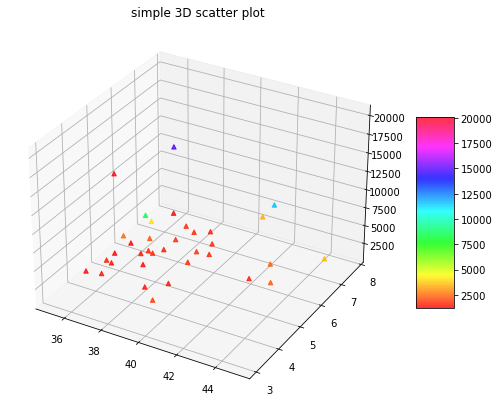

In [154]:
df['price'] = df['price'].astype(float)
df["win_rate"] = df["win_rate"].astype(float)
df["stats_agg"] = df["stats_agg"].astype(float)

test = df[(df['price'] <= 20000) & (df['win_rate'] > 35) ] # & (df['price'] <= 2250) & (df['breedTime'] == 0) & (df['gender'] == 'Male')
# test = test[test['stats_decent'] == True].sort_values(by=['price'], ascending=False)
test.head()
# df = df.dropna();
# df[df['win_rate'] == 0]
# df.shape;

# df = df[(df['price'] <= 1300) & (df['breedTime'] == 0)]
# df = df.sort_values(by=['rng_mean'], ascending=False);
# df.head()



# x = df['stats_agg'][:20]
# y = df['win_rate'][:20]

# plt.scatter(df['stats_agg'],df['win_rate'])
# plt.ylabel('Win Rate')
# plt.xlabel('Stats Agg')
# plt.show()
from mpl_toolkits import mplot3d


fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
    
my_cmap = plt.get_cmap('hsv')
y = test['rng_agg']
x = test['win_rate']
z = test['price']

# Creating plot
sctt = ax.scatter3D(x, y, z,
             alpha = 0.8,
             c = (x + y + z),
             cmap = my_cmap,
             marker ='^')
plt.title("simple 3D scatter plot")
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

 
plt.show()

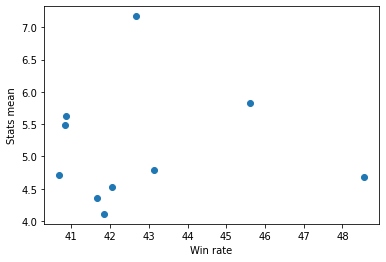

In [172]:
df['price'] = df['price'].astype(float)
df["win_rate"] = df["win_rate"].astype(float)
df["stats_agg"] = df["stats_agg"].astype(float)

test = df[(df['win_rate'] > 40)& (df['win_rate'] < 50)] # & (df['price'] <= 2250) & (df['breedTime'] == 0) & (df['gender'] == 'Male')
# test = test[test['stats_decent'] == True].sort_values(by=['price'], ascending=False)
test.head()

plt.scatter(test['win_rate'], test['stats_agg'])
plt.xlabel('Win rate')
plt.ylabel('Stats mean')
plt.show()

In [173]:
import plotly.express as px

y = df['rng_agg']
x = df['win_rate']
z = df['price']
fig = px.scatter_3d(test, x='win_rate', y='rng_agg', z='price', color='stats_decent')
fig.show()

# Price analysis for different segments 

### Less than 19% win rate

In [117]:
wr = win_rate1.sort_values(by=['price'])
# wr['price'].plot()

# print("Minimum price: {}".format(wr['price'].min()))
# print("Maximum price: {}".format(wr['price'].max()))
# print("Mean price: {:.2f}".format(wr['price'].mean()))
# print("Median price: {}".format(wr['price'].median()))

### Win rate between 20% to 30%

In [118]:
wr = win_rate2.sort_values(by=['price'])
# wr['price'].plot()

print("Minimum price: {}".format(wr['price'].min()))
print("Maximum price: {}".format(wr['price'].max()))
print("Mean price: {:.2f}".format(wr['price'].mean()))
print("Median price: {}".format(wr['price'].median()))

Minimum price: 650.0
Maximum price: 1000000.0
Mean price: 5217.37
Median price: 1039.0


### Win rate between 30% to 40% 

In [ ]:
wr = win_rate3.sort_values(by=['price'])
# wr['price'].plot()

print("Minimum price: {}".format(wr['price'].min()))
print("Maximum price: {}".format(wr['price'].max()))
print("Mean price: {:.2f}".format(wr['price'].mean()))
print("Median price: {}".format(wr['price'].median()))

### Win rate between 40% to 50%

In [ ]:
wr = win_rate4.sort_values(by=['price'])
# wr['price'].plot()

print("Minimum price: {}".format(wr['price'].min()))
print("Maximum price: {}".format(wr['price'].max()))
print("Mean price: {:.2f}".format(wr['price'].mean()))
print("Median price: {}".format(wr['price'].median()))

### Win rate greater than 50%

In [ ]:
wr = win_rate5.sort_values(by=['price'])
# wr['price'].plot()

print("Minimum price: {}".format(wr['price'].min()))
print("Maximum price: {}".format(wr['price'].max()))
print("Mean price: {:.2f}".format(wr['price'].mean()))
print("Median price: {}".format(wr['price'].median()))

In [ ]:
# win_rate2[win_rate2['price'] == 610000]

In [ ]:
test = df[df['price'] <= 3000]
test = test.sort_values(by=['win_rate'], ascending=False).head(20) 
# test = test.sort_values(by=['win_rate'], ascending=False)
print(test.head())


In [ ]:
plt.scatter(win_rate1['win_rate'], win_rate1['price'])
plt.show()

plt.scatter(win_rate2['win_rate'], win_rate2['price'])
plt.show()

plt.scatter(win_rate3['win_rate'], win_rate3['price'])
plt.show()

plt.scatter(win_rate4['win_rate'], win_rate4['price'])
plt.show()

plt.scatter(win_rate5['win_rate'], win_rate5['price'])
plt.show()


# plt.scatter(test['stats_mean'], test['win_rate'])
# plt.show()


# plt.scatter(test['price'], test['all_stats_mean'])
# plt.show()

plt.scatter(test['price'], test['rng_mean'])
plt.show()